This notebook takes borehole data and SNMR data from the East Kimberley and creates a map of water tables.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
from shapely.geometry import Polygon, shape
import fiona
import pandas as pd
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils, SNMR_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from datetime import datetime
import matplotlib.pyplot as plt
import os, sys
import sqlalchemy as db
from sqlalchemy import create_engine, event
import yaml
import rasterio
from rasterio import Affine
from rasterio.warp import reproject, Resampling
import warnings
import math
warnings.filterwarnings("ignore",category =RuntimeWarning)
# Kriging packages
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from pykrige.rk import Krige
from pykrige.compat import GridSearchCV
# Regression kriging functions
from sklearn.linear_model import Ridge
from pykrige.rk import RegressionKriging
from pykrige.compat import GridSearchCV
from pykrige.compat import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def find_optimal_index(pred_prob):
    # Find the index of the optimal place to put the water table
    
    # If all the probabilities for class one are less than 0.5 then we return a 
    # None and assume the water table is dry for the depth interval of investigation
    
    if np.max(pred_prob[:,1]) < 0.5:
        return None
    
    else:
        # Iterate through the NMR layers and find the average of the 
        # probabilities of being in class 1 (saturated) for all layers
        # below the layer
    
        objective = np.nan*np.ones(shape = pred_prob[:,0].shape, dtype = np.float)
        
        # For the first layer we use the p(saturated of layer 1)
        objective[0] = pred_prob[0,1]

        for i in range(1,pred_prob.shape[0]):
            # For subsequent layers we sum the probability of all layers below being in class
                # one with the probability of all layers above not being in class one
            objective[i] = (np.mean(pred_prob[i:,1]) + 1 - np.mean(pred_prob[:i,1]))/2
            
        return np.argmax(objective)
        

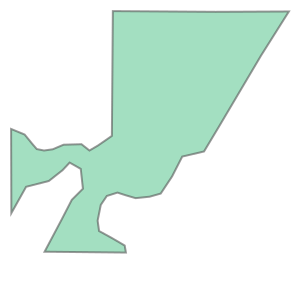

In [4]:
# Open geometry for a shapefile. This will be used to filter the bores extracted from the database
c = fiona.open(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\Keep_spatial\Keep_River_polygons.shp")
collection = [ shape(item['geometry']) for item in c ]
names = [item['properties']['Name'] for item in c]
polygons = [Polygon(pol.exterior.coords) for pol in collection] 

# Display
#OrdKeep = polygons[names.index('Wider_Keep')]
OrdKeep = polygons[names.index('water_table_clip')]

OrdKeep

In [5]:
# Extract data from the database

path = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_borehole_data.sqlite")

SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()


In [6]:
# Custom query so we can join on the standing water level table

query = """

select
   b.borehole_id,
   b.Borehole_name,
   b.Easting,
   b.Northing,
   b.Ground_elevation_mAHD,
   swl.Date,
   swl.Depth

from

   borehole b
   left join standing_water_level  swl on b.borehole_id = swl.borehole_id
   
where

   within(b.geom,GeomFromText('{}'))
   
and

   b.SWL_available = 1;""".format(OrdKeep)


df_swl = pd.read_sql(query, connection)

# Rename the depth column
df_swl = df_swl.rename(columns = {"Depth": "SWL_depth"})

In [7]:
# Extract the borehole ids into an array

enos = df_swl['borehole_id'].unique()


In [8]:

# Find the days since the measurement was taken
date_format = "%Y-%m-%d"
today = datetime.now()
days_ago= [(today - datetime.strptime(x, date_format)).days for x in df_swl['Date']]
df_swl['days_since_swl'] = days_ago


In [9]:
# For duplicate entries we will drop the measurements that were taken longer ago

# Minimum indices will be added to a list
min_ind = []

# Iterate through the enos
for item in enos:
    # Get the subset using the eno as a mask
    df_subset = borehole_utils.extract_by_primary_key(df_swl,[item])
    # Find the minumum index using the days since the measurement was takes
    min_ind.append(df_subset['days_since_swl'].argmin())

# Filter usign the minimum index
df_swl = df_swl.loc[min_ind,:] 

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  # This is added back by InteractiveShellApp.init_path()


In [10]:
# Drop the pesky artesian well, this is conined and thus not usefule
# for defining a water table surface

df_swl = df_swl[df_swl["SWL_depth"] > 0.]

In [11]:
# Create a water level elevation column

df_swl['wl_mAHD'] = df_swl['Ground_elevation_mAHD'] - df_swl['SWL_depth']

utm_zone = 52
46 points in UTM bounding box: [481885.0, 8274026.4, 533361.5, 8322488.629]


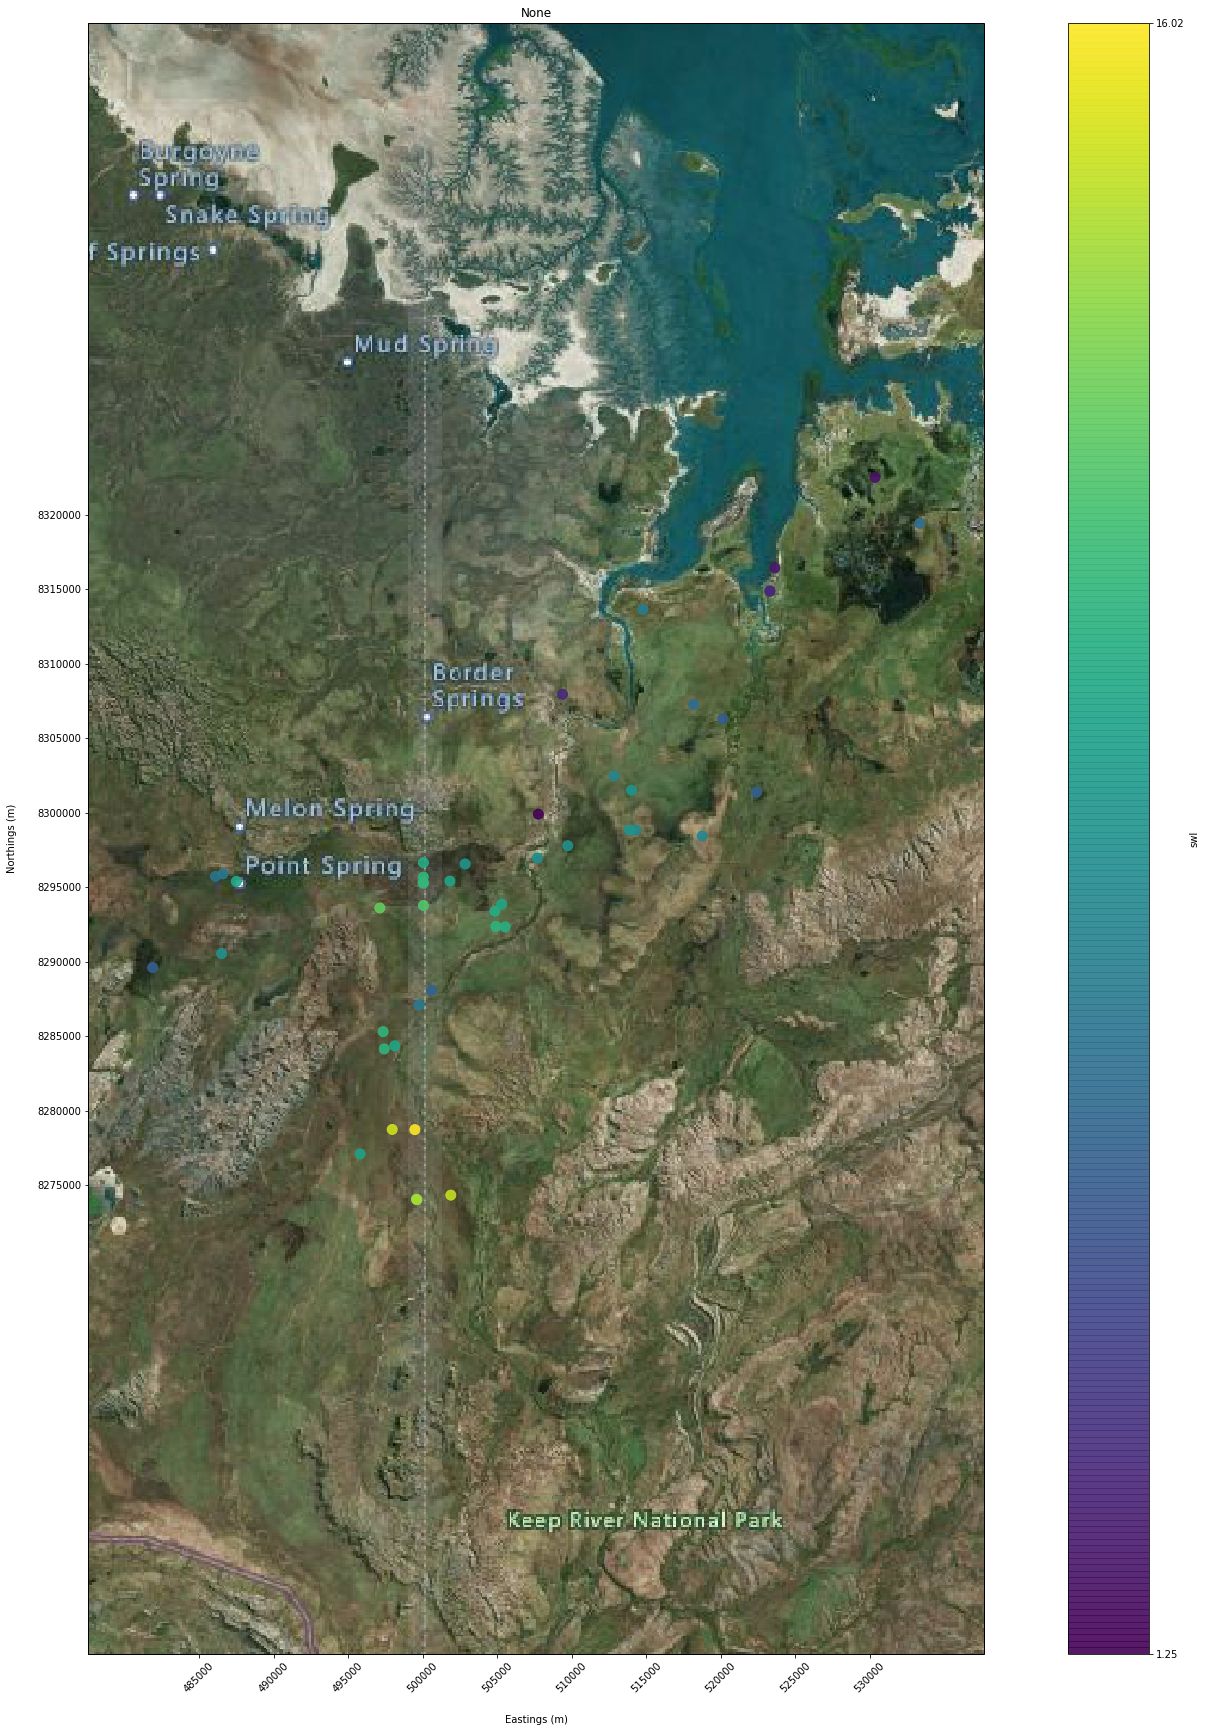

In [12]:
# Plot the bores on a basemap to get an idea of what the swl data looks like

bore_coords = df_swl[['Easting', 'Northing']].values


swl = df_swl["SWL_depth"].values
#wl_mAHD = df_swl["SWL_depth"].values

plotting_utils.plot_point_dataset(bore_coords, "EPSG:28352", swl, 
                   colourbar_label = 'swl', colour_scheme = 'viridis',
                    point_size=100)


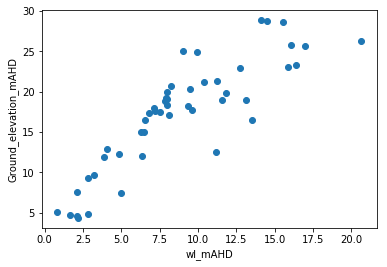

In [20]:
# To demonstrate the relationship between the groundwater elevation and ground elevation we 
# run a scatter plot


plt.scatter(df_swl['wl_mAHD'].values,
           df_swl['Ground_elevation_mAHD'].values)

plt.xlabel('wl_mAHD')
plt.ylabel('Ground_elevation_mAHD')

plt.show()

While there is some scatter here the trend is clearly linear. Our next attempt is to model the water table using regression kriging.

In [26]:
df_swl

,borehole_id,Borehole_name,Easting,Northing,Ground_elevation_mAHD,Date,SWL_depth,days_since_swl,wl_mAHD,lid50m_elevation_mAHD,lid50m_slope
1,626981,RN029663,509738.000,8297777.000,14.936,2016-10-19,8.635,901,6.301,14.849471,0.322045
3,626984,RN034821,514784.000,8313635.000,12.281,2017-10-07,7.450,548,4.831,12.148163,0.913838
5,626986,RN029660,500047.884,8295266.378,19.217,2016-10-18,11.290,902,7.927,19.119029,0.195385
7,626987,RN029665,512860.000,8302461.000,11.873,2016-10-20,7.975,900,3.898,11.985136,0.171667
9,626988,RN029653,514021.000,8301501.000,12.904,2016-10-20,8.825,900,4.079,12.900905,0.148205
10,626989,RN029656,504845.000,8293381.000,17.650,2016-10-20,10.430,900,7.220,17.520233,0.104250
12,626990,RN029666,518194.000,8307268.000,9.266,2016-10-19,6.460,901,2.806,9.333680,0.131756
14,626991,RN029662,500590.000,8288080.000,18.952,2017-09-30,5.820,555,13.132,18.973789,0.202954
17,626992,RN030826,501892.000,8274331.000,28.793,2017-10-01,14.660,554,14.133,28.846032,0.191896
19,635728,RN040873,520144.760,8306293.880,7.519,2018-11-11,5.440,148,2.079,8.340292,0.378587


In [15]:
# Our next tak is to bring the SNMR data in 

# Connect to the SNMR database

DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\NMR\SNMR\East_Kimberley_SNMR.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

query = """

SELECT
              s.site_id,
              s.Field_ID,
              s.mid_X,
              s.mid_Y,
              a.acquisition_id,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.pulse_sequence == "FID"

and

            within(s.geom,GeomFromText('{}'));""".format(OrdKeep)

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Since we are interested in the shallow resolution we will use the shorter pulse SNMR


df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = ['FID'],
                                 pulse_length_criteria="min")]



In [16]:
# Now extract the SNMR inversions

acquisition_ids = df_acquisitions.index

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id']

df_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = True)[cols]


# Join the SNMR inversions on acquisition and sites

df_inversions = df_inversions.merge(df_acquisitions, how='inner', left_on='acquisition_id',
                                    right_index=True, )


In [17]:
df_inversions.head(24)

,Depth_from,Depth_to,Mobile_water_content,Bound_water_content,Total_water_content,T2*,acquisition_id,inversion_id,site_id,Field_ID,mid_X,mid_Y,pulse_sequence,pulse_length,Depth_of_Investigation
table_id,,,,,,,,,,,,,,,
2300,0.424358,0.584135,0.090960,0.108165,0.199125,0.021730,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2301,0.584135,0.779694,0.114902,0.244187,0.359089,0.015200,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2302,0.779694,1.014651,0.094979,0.121004,0.215983,0.021756,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2303,1.014651,1.292620,0.000000,0.000000,0.000000,2.408116,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2304,1.292620,1.617217,0.176056,0.377310,0.553366,0.018704,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2305,1.617217,1.992058,0.037486,0.109043,0.146529,2.999998,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2306,1.992058,2.420758,0.014329,0.074370,0.088699,2.999957,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2307,2.420758,2.906933,0.054042,0.000000,0.054042,2.999992,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2308,2.906933,3.454198,0.000000,0.000000,0.000000,0.181596,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173


In [18]:
# Now we want to discover any colocated sites

SNMR_coords = df_acquisitions[['mid_X', 'mid_Y']].values

distances, indices = spatial_functions.nearest_neighbours(bore_coords,
                                                         SNMR_coords,
                                                         points_required = 1,
                                                         max_distance = 200.)


In [19]:
df_swl['co-located_SNMR_site_id'] = -999

# Iterate through the bores and if a site was returned
# add the site id to the dataframe
for i, (index, row)  in enumerate(df_swl.iterrows()):
    idx = indices[i]
    if idx != len(df_acquisitions):
        # Sincve we only have one acquisition per site we can use site_id
        df_swl.at[index, 'co-located_SNMR_site_id'] = df_acquisitions['site_id'].iloc[idx]

In [20]:
df_swl

,borehole_id,Borehole_name,Easting,Northing,Ground_elevation_mAHD,Date,SWL_depth,days_since_swl,wl_mAHD,co-located_SNMR_site_id
1,626981,RN029663,509738.000,8297777.000,14.936,2016-10-19,8.635,902,6.301,-999
3,626984,RN034821,514784.000,8313635.000,12.281,2017-10-07,7.450,549,4.831,-999
5,626986,RN029660,500047.884,8295266.378,19.217,2016-10-18,11.290,903,7.927,263
7,626987,RN029665,512860.000,8302461.000,11.873,2016-10-20,7.975,901,3.898,-999
9,626988,RN029653,514021.000,8301501.000,12.904,2016-10-20,8.825,901,4.079,78
10,626989,RN029656,504845.000,8293381.000,17.650,2016-10-20,10.430,901,7.220,-999
12,626990,RN029666,518194.000,8307268.000,9.266,2016-10-19,6.460,902,2.806,-999
14,626991,RN029662,500590.000,8288080.000,18.952,2017-09-30,5.820,556,13.132,-999
17,626992,RN030826,501892.000,8274331.000,28.793,2017-10-01,14.660,555,14.133,-999
19,635728,RN040873,520144.760,8306293.880,7.519,2018-11-11,5.440,149,2.079,233


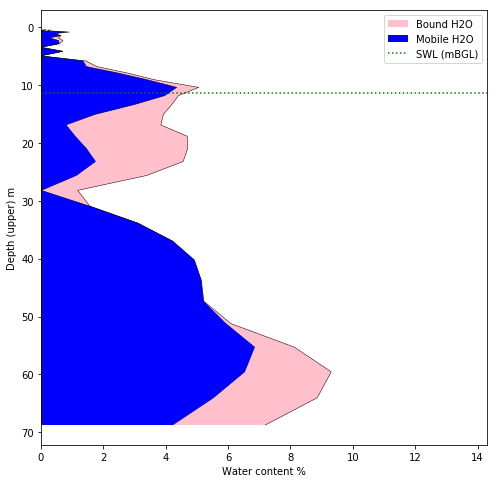

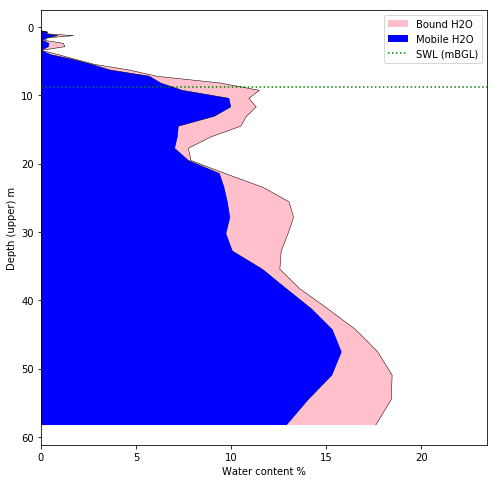

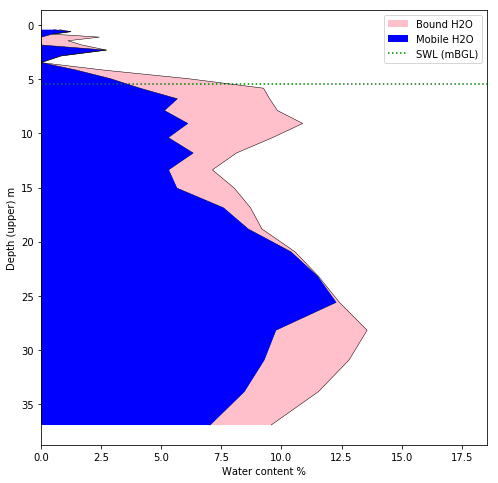

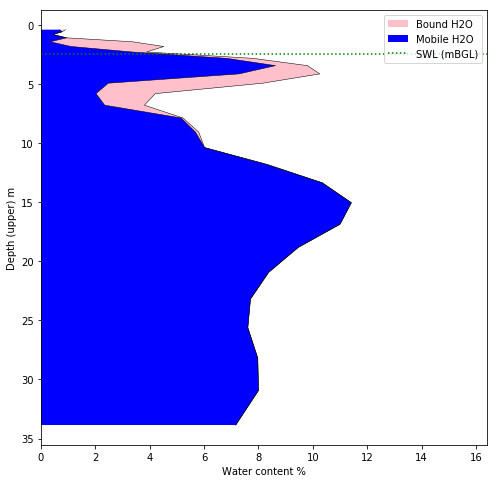

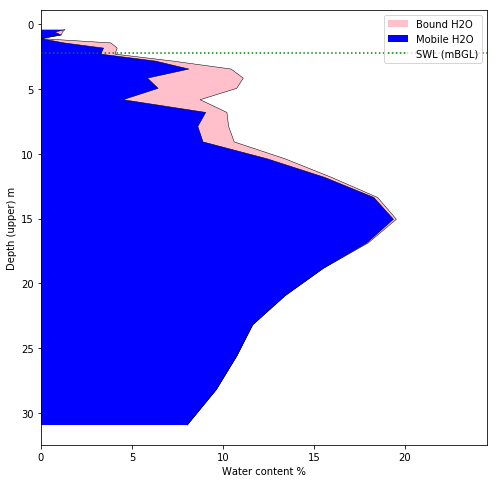

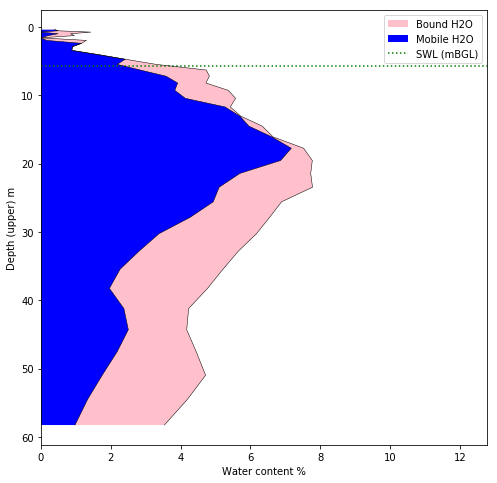

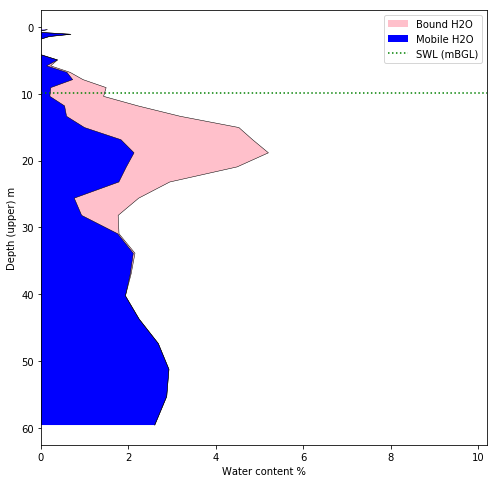

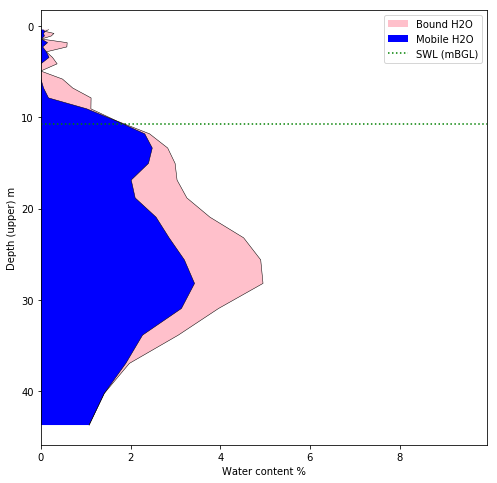

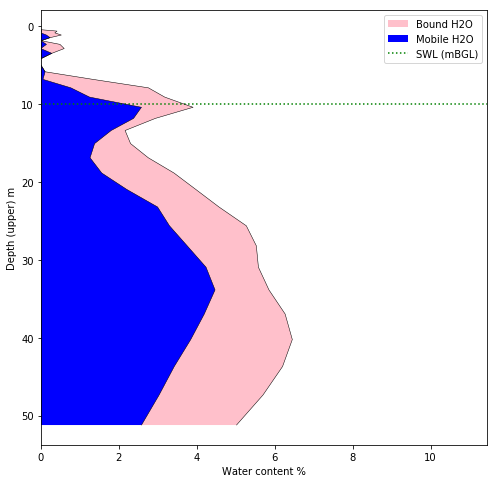

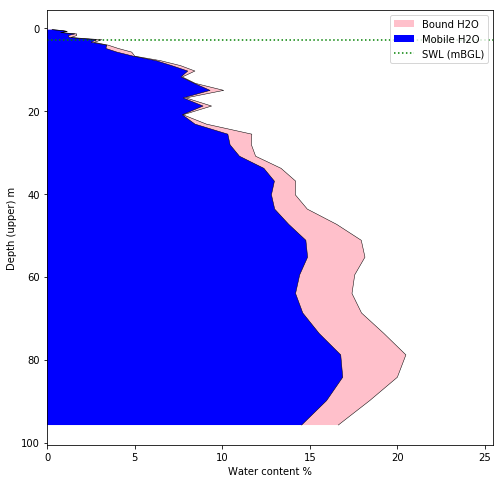

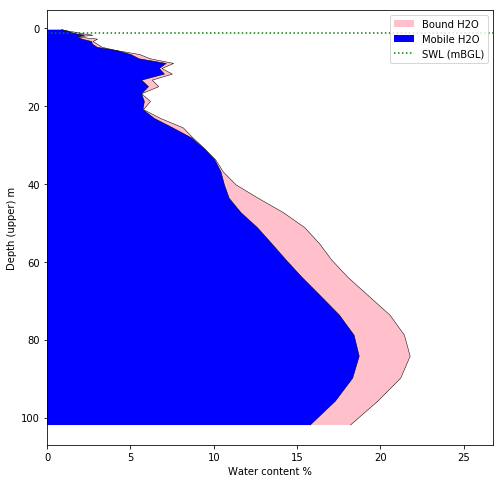

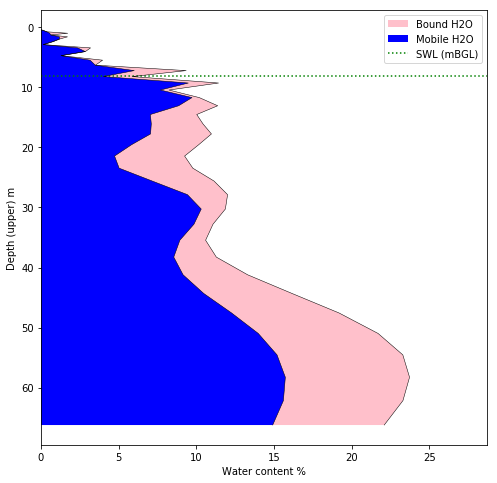

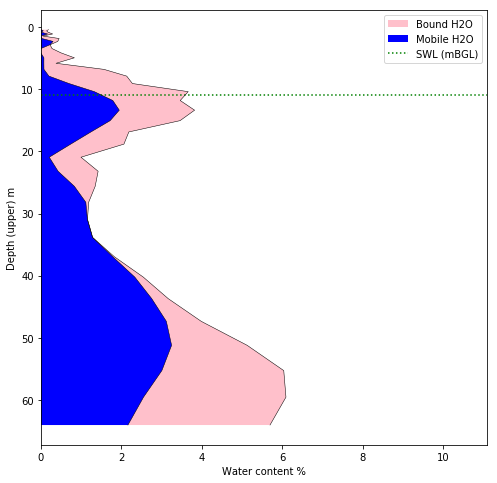

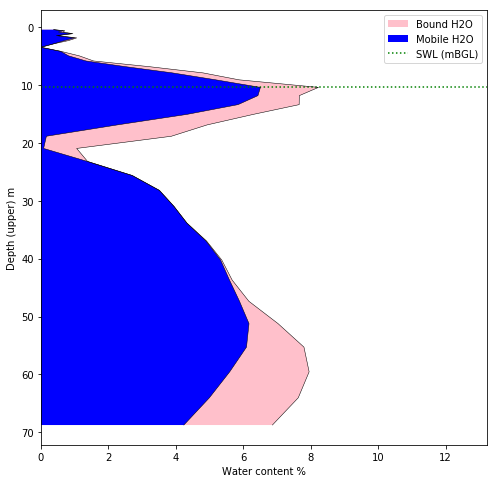

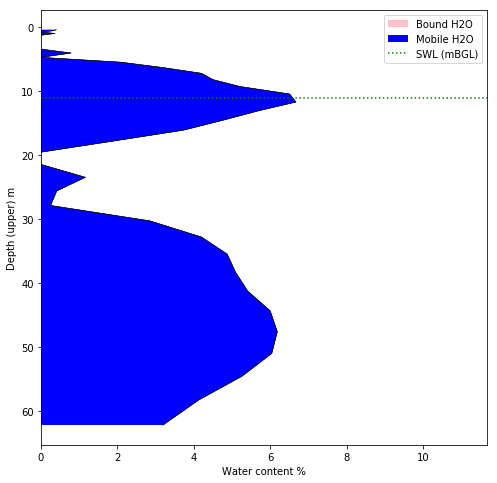

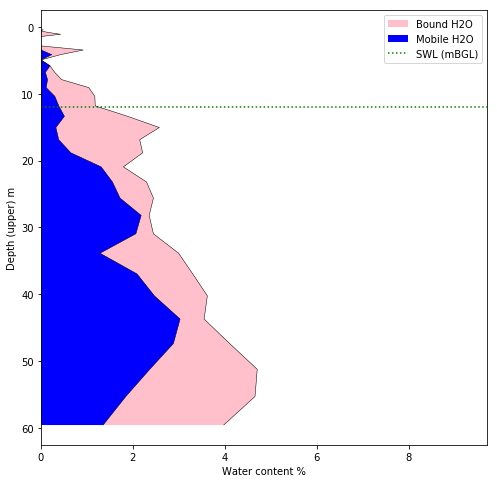

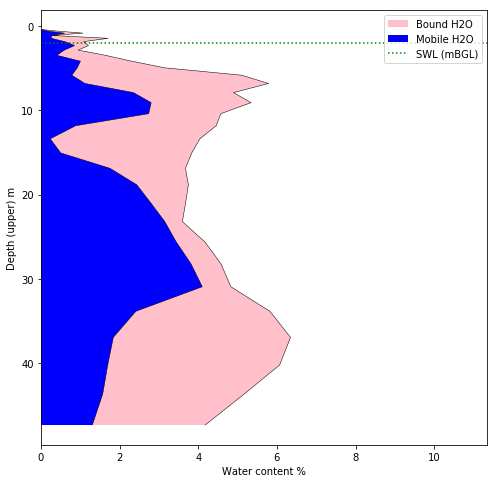

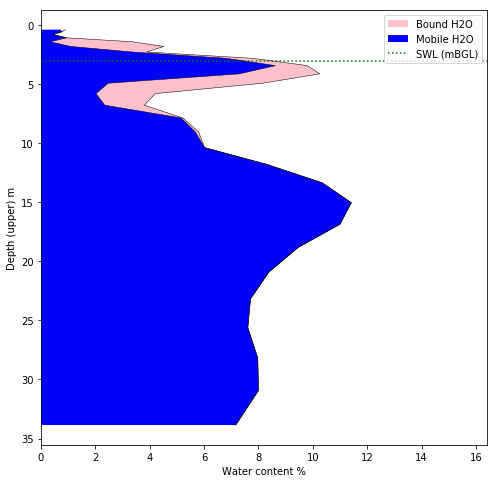

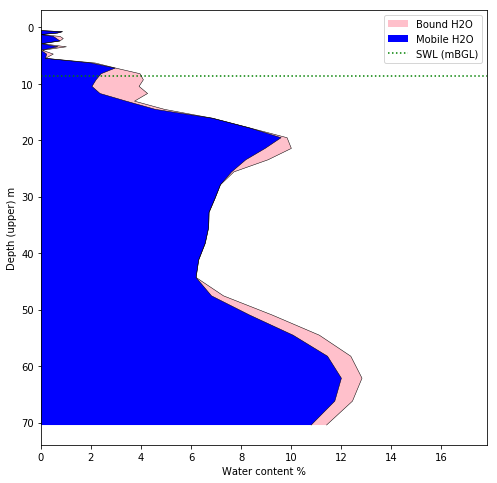

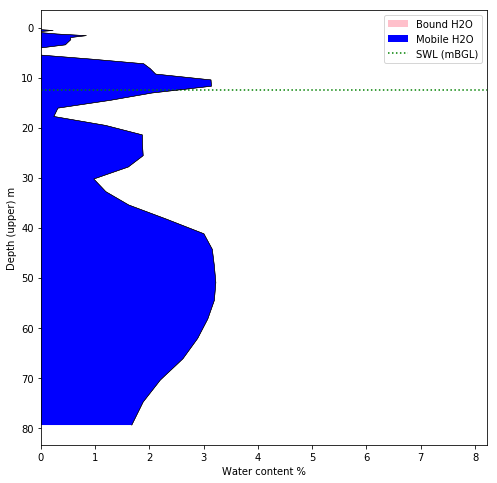

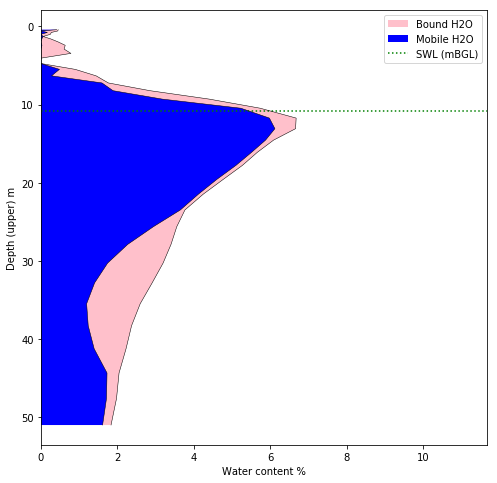

In [21]:
# For each bore with a standing water level plot
# the level on a plot of water level

mask = df_swl['co-located_SNMR_site_id'] != -999

df_swl_subset = df_swl[mask]

# Define outdir

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\plots"


for index, row in df_swl_subset.iterrows():
    site_id = row['co-located_SNMR_site_id']
    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site_id]
    # Create a plot
    fig, ax = plt.subplots(1,1,figsize = (8,8))
    
    # Add standing water level
    swl_depth = row['SWL_depth']
    
    field_id = df_acquisitions[df_acquisitions['site_id'] == site_id]['Field_ID'].values[0]
    
    SNMR_utils.plot_profile(ax, SNMR_inversion, doi = None,
                           plot_mobile_water=True)
    # REverse the axis so the gorund is up
    plt.gca().invert_yaxis()
    
    # Plot the water table as a line
    
    ax.hlines(swl_depth, ax.get_xlim()[0], ax.get_xlim()[1],
                  color='green', linestyles='dotted', label = 'SWL (mBGL)')
    
    ax.legend()

    
    fname = row['Borehole_name'] + '_' + field_id + "_comparison_plot.png"
    
    plt.savefig(os.path.join(outdir, fname))
    
    
    

In [22]:
# Calculate key attributes for the optimisation exercise

# Find the mean and standard deviation of a moving window for the mobile water

new_cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id',
       'site_id', 'Field_ID', 'mid_X', 'mid_Y', 'pulse_sequence',
       'pulse_length', 'Depth_of_Investigation',
       'Total_water_content_zero_mean', 'Total_water_content_CV_4',
       'Total_water_content_gradient_4', 'Total_water_content_CV_6',
       'Total_water_content_gradient_6', 'Total_water_content_CV_8',
       'Total_water_content_gradient_8', 'Mobile_water_content_zero_mean',
       'Mobile_water_content_CV_4', 'Mobile_water_content_gradient_4',
       'Mobile_water_content_CV_6', 'Mobile_water_content_gradient_6',
       'Mobile_water_content_CV_8', 'Mobile_water_content_gradient_8',
       'saturated']

df_SNMR_params = pd.DataFrame(columns = new_cols)

window_size = [2,4,6,8]

parameters = ['Total_water_content', 'Mobile_water_content']

for index, row in df_swl_subset.iterrows():
    site_id = row['co-located_SNMR_site_id']
    swl = row['SWL_depth']
    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site_id]
    
    # Since we are only intereseted in the top 40 metres or so lets filter the 
    # data frame for the near surface
    SNMR_inversion =  SNMR_inversion[ SNMR_inversion['Depth_to'] < 40.]
    
    # Iterate through the metrixcs
    for param in parameters:
        
        a = SNMR_inversion[param]
    
        # Get mean-zero water content
        SNMR_inversion[param + '_zero_mean'] = a - np.mean(a)
        
        for wind in window_size:
        # Calculate the rolling mean
            rolling_mean = a.rolling(wind,
                                     min_periods = 1).mean()  + 0.001 # Guard agianst dividing by 0
            rolling_std = a.rolling(wind, 
                                    min_periods = 1).std()
            # Coefficient of variation
            SNMR_inversion[param + '_CV' + '_' + str(wind)] = np.divide(rolling_std, rolling_mean)
            
            # Get the gradient
            SNMR_inversion[param + '_gradient' + '_' + str(wind)] = np.gradient(a.rolling(center=False, min_periods = 2,
                                                                                                      window=wind).mean())
            
    
    # Add a label for saturated or no or transition (0.5)
    SNMR_inversion['saturated'] = 0.5
    
    # All values above the water table labeled as unsaturated
    SNMR_inversion.at[SNMR_inversion[SNMR_inversion['Depth_to'] < swl].index, 'saturated'] = 0
    
    SNMR_inversion.at[SNMR_inversion[SNMR_inversion['Depth_from'] > swl].index, 'saturated'] = 1
    
    
    df_SNMR_params = df_SNMR_params.append(SNMR_inversion).dropna()

df_training = df_SNMR_params[df_SNMR_params['saturated'] != 0.5]

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


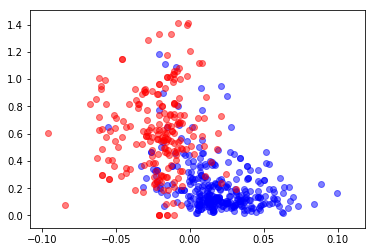

In [23]:
# Scatter plot the zero meaned and coefficient of variation

fig, ax1 = plt.subplots(1,1)

saturated = df_SNMR_params[df_SNMR_params['saturated'] == 1.]
unsaturated = df_SNMR_params[df_SNMR_params['saturated'] == 0.]

ax1.scatter(saturated['Total_water_content_zero_mean'].values, saturated['Total_water_content_CV_4'].values,
           c= 'blue', alpha = 0.5)
ax1.scatter(unsaturated['Total_water_content_zero_mean'].values, unsaturated['Total_water_content_CV_4'].values,
           c= 'red', alpha = 0.5)

plt.show()

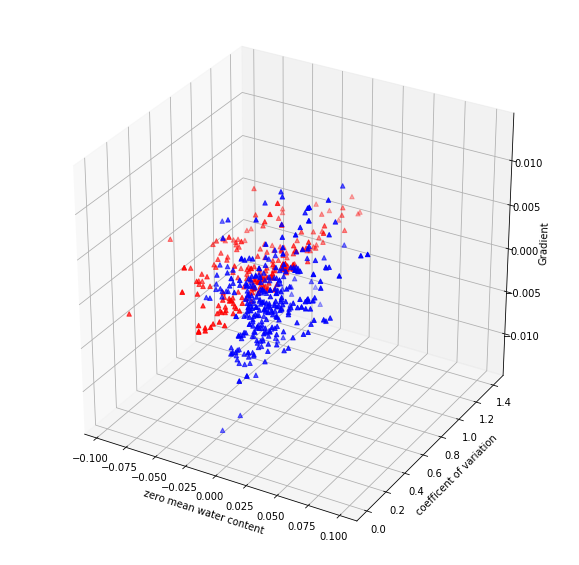

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

saturated = df_SNMR_params[df_SNMR_params['saturated'] == 1.]
unsaturated = df_SNMR_params[df_SNMR_params['saturated'] == 0.]

ax.scatter(saturated['Total_water_content_zero_mean'].values,
           saturated['Total_water_content_CV_4'].values,
           saturated['Total_water_content_gradient_8'].values, c = 'blue', marker = '^')
           

ax.scatter(unsaturated['Total_water_content_zero_mean'].values,
           unsaturated['Total_water_content_CV_4'].values,
           unsaturated['Total_water_content_gradient_8'].values, c = 'red', marker = '^')

ax.set_xlabel('zero mean water content')
ax.set_ylabel('coefficent of variation')
ax.set_zlabel('Gradient')

plt.show()

In [25]:
# Train a classifier on this to get probability of saturation given
# the zero mean, coefficient of variation and gradient

# WE ignore the transition zone so it is a binary classification

from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

train_cols = ['Total_water_content_zero_mean',
             'Total_water_content_gradient_8',
             'Total_water_content_CV_6',
             'Total_water_content']



X = df_training[train_cols].values
y = df_training['saturated'].astype(int).values

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75,
                                                    test_size=0.25, shuffle=True)

# WE use tpot to pick the best pipeline

tpot = TPOTClassifier(verbosity=2, max_time_mins=3)

tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.9724050632911393
Generation 2 - Current best internal CV score: 0.9724050632911393

3.0056672 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=1.0, max_depth=2, max_features=0.7000000000000001, min_samples_leaf=14, min_samples_split=3, n_estimators=100, subsample=0.8500000000000001)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=1000000,
        max_eval_time_mins=5, max_time_mins=3, memory=None,
        mutation_rate=0.9, n_jobs=1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=100,
        random_state=None, scoring=None, subsample=1.0, use_dask=False,
        verbosity=2, warm_start=False)

In [26]:
# Test the classifier on the test set

tpot.score(X_test, y_test)
tpot.export(r"C:\temp\tpot_mnist_pipeline.py")

# This is a good score

In [27]:
# Now we trial a few combinations of parameters, we will 
# judge the results by the cross validation score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

# Define the three variables


for par in parameters:
    # Window size for the gradient variables
    for gradient_wind in window_size:
        for cv_wind in window_size:
            # Define columns and extract data
            cols = [par + '_zero_mean', par + '_gradient_' + str(gradient_wind),
                   par + '_CV_' + str(cv_wind), par]
            X = df_training[cols].values
            y = df_training['saturated'].astype(int).values
            clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=6,
                                             max_features=0.05, min_samples_leaf=4,
                                             min_samples_split=10, n_estimators=100, subsample=0.25)
            
            # Cross validation
            try:
                cv_results = cross_validate(clf, X, y, cv=5, return_train_score=False)
                print(cols)
                print(np.mean(cv_results['test_score']))
                # Add results to the dicitonary
            except ValueError:
                pass

        


['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_2', 'Total_water_content']
0.9019193725806318
['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_4', 'Total_water_content']
0.9207520299602825
['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_6', 'Total_water_content']
0.9433765775751317
['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_8', 'Total_water_content']
0.9302575341545541
['Total_water_content_zero_mean', 'Total_water_content_gradient_4', 'Total_water_content_CV_2', 'Total_water_content']
0.9206991292373059
['Total_water_content_zero_mean', 'Total_water_content_gradient_4', 'Total_water_content_CV_4', 'Total_water_content']
0.9244723782653601
['Total_water_content_zero_mean', 'Total_water_content_gradient_4', 'Total_water_content_CV_6', 'Total_water_content']
0.9339243099814428
['Total_water_content_zero_mean', 

In [28]:
cv_results

{'fit_time': array([0.09800982, 0.09400964, 0.09500933, 0.09200907, 0.09300947]),
 'score_time': array([0.        , 0.        , 0.        , 0.00099993, 0.00099993]),
 'test_score': array([0.93457944, 0.91588785, 0.94339623, 0.80188679, 0.94285714])}

In [58]:
cv_wind = 8
grad_wind = 6

cols = ['Total_water_content_zero_mean', 'Total_water_content_gradient_' + str(grad_wind),
        'Total_water_content_CV_' + str(cv_wind),
       'Total_water_content']

X = df_training[cols].values

y = df_training['saturated'].astype(int).values

clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=6,
                                 max_features=0.05, min_samples_leaf=4,
                                 min_samples_split=10, n_estimators=100, subsample=0.25)

clf.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=0.05, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.25, verbose=0,
              warm_start=False)

In [59]:
cols

['Total_water_content_zero_mean',
 'Total_water_content_gradient_6',
 'Total_water_content_CV_8',
 'Total_water_content']

In [64]:
# Now lets use this to predict the rest of our SNMR soundings

# Cut out only the top 40 metres

df_inversions = df_inversions[df_inversions['Depth_to'] < 40.]


# Find the mean and standard deviation of a moving window for the mobile water

for site in df_inversions.site_id.unique():

    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site]
    
    # Iterate through the metrixcs
    a = SNMR_inversion['Total_water_content']
    
    # Get mean-zero water content
    SNMR_inversion['Total_water_content_zero_mean'] = a - np.mean(a)
    
    # Get the optimal gradient
    # Calculate the rolling mean
    rolling_mean = a.rolling(cv_wind, min_periods = 1).mean() + 0.001 # Guard agianst dividing by 0
    rolling_std = a.rolling(cv_wind, min_periods = 1).std()
    
    # Calculate coefficient of variation
    SNMR_inversion['Total_water_content_CV'] = np.divide(rolling_std, rolling_mean)
            
    # Get the gradient
    SNMR_inversion['Total_water_content_gradient'] = np.gradient(a.rolling(center=False, min_periods = 2,
                                                                           window=grad_wind).mean())
    SNMR_inversion = SNMR_inversion.dropna()
    
    # Now predict the saturation of the profile
    X = SNMR_inversion[['Total_water_content_zero_mean',
                        'Total_water_content_gradient',
                        'Total_water_content_CV',
                        'Total_water_content']]
    
    pred = clf.predict(X)
    
    pred_prob =clf.predict_proba(X)
    # Get the optimal change point
    
    idx = find_optimal_index(pred_prob)
    
    # Estimate the water table at each site
    if idx is not None:
        water_table = SNMR_inversion['Depth_from'].iloc[idx]
    
        # Add to the acquisitions dataframe
        ind = df_acquisitions[df_acquisitions['site_id'] == site].index
    
        df_acquisitions.at[ind, 'modelled_water_table'] = water_table
    else:
        print(site)

    

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

243


In [65]:
# Now we plot these over the profiles

# Define outdir

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\water_table_plots_run2"

if not os.path.exists(outdir):
    os.mkdir(outdir)


for index, row in df_acquisitions.iterrows():
    
    site_id = row['site_id']
    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site_id]
    # Create a plot
    fig, ax = plt.subplots(1,1,figsize = (8,8))
    
    # Add standing water level
    water_table = row['modelled_water_table']
    
    field_id = row['Field_ID']
    
    SNMR_utils.plot_profile(ax, SNMR_inversion, doi = None,
                           plot_mobile_water=True)
    
    # REverse the axis so the gorund is up
    plt.gca().invert_yaxis()
    
    # Plot the water table as a line
    
    ax.hlines(water_table, ax.get_xlim()[0], ax.get_xlim()[1],
                  color='green', linestyles='dotted', label = 'modelled water table')
    
    # Add SWL if available
    if site_id in df_swl['co-located_SNMR_site_id'].values:
        
        swl = df_swl[df_swl['co-located_SNMR_site_id'] == site_id]['SWL_depth'].values[0]
        
        ax.hlines(swl, ax.get_xlim()[0], ax.get_xlim()[1],
                  color='blue', linestyles='dashed', label = 'SWL')
        
        
        
    ax.legend()

    
    fname = field_id + "_modelled_water_table_plot.png"
    
    plt.savefig(os.path.join(outdir, fname))
    
    plt.close()

In [66]:
df_compare = df_swl.merge(df_acquisitions, left_on = 'co-located_SNMR_site_id',
            right_on = 'site_id')

df_compare['RMSE'] = np.sqrt(np.square(df_compare['SWL_depth'].values - df_compare['modelled_water_table'].values))

print(df_compare['RMSE'].mean())

df_compare.to_csv(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\results\swl_snmr_modelling_comparison_run2.csv")

0.7457164428571427


In [67]:
# Now we will create an xy water table depth dataset to interpolate

# Drop nas from the df_acquisitions

df_snmr_watertable = df_acquisitions.dropna(subset = ['modelled_water_table'])[['Field_ID','site_id','mid_X', 'mid_Y',
                                                                                'modelled_water_table']]

# Now drop columns that have swl assosicates

df_snmr_watertable[~df_snmr_watertable['site_id'].isin(df_swl['co-located_SNMR_site_id'].values)]

# Now get the x,y,depth as arrays

snmr_wt = df_snmr_watertable[['Field_ID','mid_X', 'mid_Y','modelled_water_table']].rename(columns = {'Field_ID':'id',
                                                                                                    'mid_X': 'Easting',
                                                                                        'mid_Y': 'Northing',
                                                                                         'modelled_water_table':
                                                                                         'water_table_depth'})
# Add uncertainty estimates

snmr_wt['uncertainty'] = 4.

snmr_wt['source'] = 'SNMR_modelled'

In [68]:
snmr_wt

,id,Easting,Northing,water_table_depth,uncertainty,source
acquisition_id,,,,,,
48,WANT_t1_S6,499969.9650,8289545.684,0.779694,4.0,SNMR_modelled
49,WANT_t1_S2,500165.9994,8293587.614,0.779694,4.0,SNMR_modelled
50,WANT_t1_S4A,500131.4116,8291852.549,1.292620,4.0,SNMR_modelled
51,KRP_fz4_S1,510620.4141,8304741.162,5.498686,4.0,SNMR_modelled
52,KRP_fz4_S2,510920.8857,8305320.149,2.420758,4.0,SNMR_modelled
53,KRP_fz4_S3,511376.2930,8305707.189,5.498686,4.0,SNMR_modelled
125,KRP_t5_s2,514186.9804,8303026.579,8.223142,4.0,SNMR_modelled
127,KRP_tlwg_s6,514256.3671,8304163.589,7.233412,4.0,SNMR_modelled
128,KRP_t1_s9,519065.7810,8304968.832,1.617217,4.0,SNMR_modelled


In [69]:
df_swl_ = df_swl[['Borehole_name','Easting', 'Northing', 'SWL_depth']]
df_swl_.rename(columns = {'Borehole_name':'id',
                          'SWL_depth': 'water_table_depth'}, inplace = True)

df_swl_['uncertainty'] = 0.1

df_swl_['source'] = 'borehole_measurement'

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [70]:
df_swl_

,id,Easting,Northing,water_table_depth,uncertainty,source
1,RN029663,509738.000,8297777.000,8.635,0.1,borehole_measurement
3,RN034821,514784.000,8313635.000,7.450,0.1,borehole_measurement
5,RN029660,500047.884,8295266.378,11.290,0.1,borehole_measurement
7,RN029665,512860.000,8302461.000,7.975,0.1,borehole_measurement
9,RN029653,514021.000,8301501.000,8.825,0.1,borehole_measurement
10,RN029656,504845.000,8293381.000,10.430,0.1,borehole_measurement
12,RN029666,518194.000,8307268.000,6.460,0.1,borehole_measurement
14,RN029662,500590.000,8288080.000,5.820,0.1,borehole_measurement
17,RN030826,501892.000,8274331.000,14.660,0.1,borehole_measurement
19,RN040873,520144.760,8306293.880,5.440,0.1,borehole_measurement


In [77]:
# Create an array with x, y, water table and an estimate of uncertainty
df_water_tables = df_swl_.append(snmr_wt)


outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\water_table_plots_run2"

for index, row in df_water_tables.iterrows():
    if row['source'] == "SNMR_modelled":
        df_water_tables.at[index, 'link'] = os.path.join(outdir, row['id'] + "_modelled_water_table_plot.png")

df_water_tables.to_csv(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\results\Keep_water_table_run2.csv")

In [74]:
# There are some dodgy sites, remove for now

bad_sites = ['KCP_nst1_S6', "WANT_t1_S6"]

df_water_tables_subset = df_water_tables[~df_water_tables['id'].isin(bad_sites)]

utm_zone = 52
148 points in UTM bounding box: [481508.7993, 8273817.002, 533567.1795, 8324310.969]


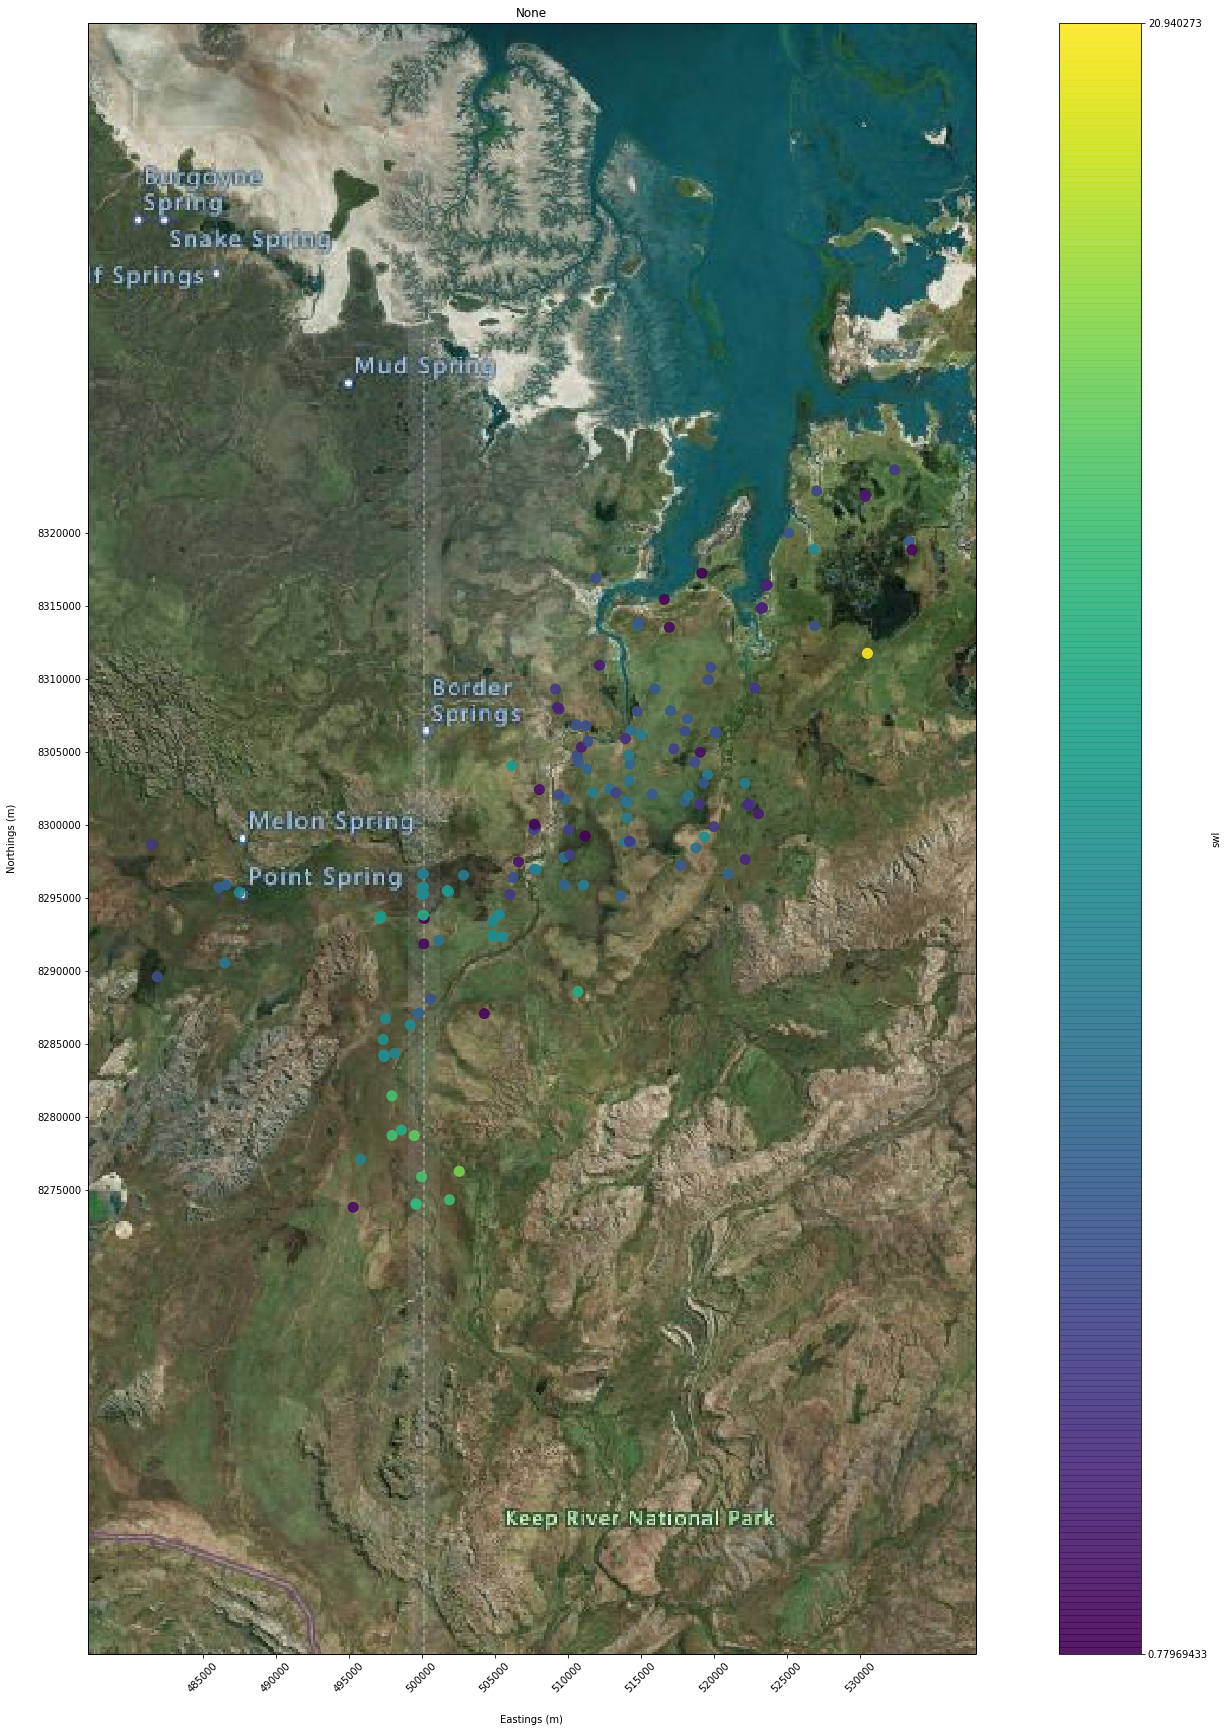

In [75]:
# Plot the bores on a basemap to get an idea of what the swl data looks like

coords = df_water_tables_subset[['Easting', 'Northing']].values


wt = df_water_tables_subset["water_table_depth"].values
#wl_mAHD = df_swl["SWL_depth"].values

plotting_utils.plot_point_dataset(coords, "EPSG:28352", wt, 
                   colourbar_label = 'swl', colour_scheme = 'viridis',
                    point_size=100)


In [140]:
# Create a new grid using the extents of the boehole data we are modelling
X = df_water_tables_subset['Easting']
Y = df_water_tables_subset['Northing']

# Define grid
gridx = np.arange((math.floor(X.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(X.max() / 10.0)) * 10 + 1000., 100)

gridy = np.arange((math.floor(Y.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(Y.max() / 10.0)) * 10 + 1000., 100)[::-1]

# WE are going to interpolate elevation data onto this grid using the lidar
tif_file = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\LiDAR\LiDAR_final\EK_LiDAR_cubic_10x10.tif'

# Define the temporary output for the grid

elev_outfile = r"C:\temp\lidar_elev_100m.tif"

# Create the new file
spatial_functions.resample_raster(tif_file, elev_outfile, gridx, gridy, driver='GTiff',
                 null = -9999)


# Create the new file
spatial_functions.resample_raster(tif_file, slope_outfile, gridx, gridy, driver='GTiff',
                 null = -9999)

In [141]:
# Open the new file
elev_src = rasterio.open(elev_outfile)

# Iterator yielding the nearest neighbour
vals = elev_src.sample(coords)

# Add the 50 m grid elevation to the dataframe
df_water_tables_subset['lid100m_elevation_mAHD'] = np.nan

for index, row in df_water_tables_subset.iterrows():

    df_water_tables_subset.at[index, 'lid100m_elevation_mAHD'] = next(vals)[0]


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [145]:
df_water_tables_subset

,id,Easting,Northing,water_table_depth,uncertainty,source,lid100m_elevation_mAHD
1,RN029663,509738.0000,8297777.000,8.635000,0.1,borehole_measurement,14.850189
3,RN034821,514784.0000,8313635.000,7.450000,0.1,borehole_measurement,12.677262
5,RN029660,500047.8840,8295266.378,11.290000,0.1,borehole_measurement,19.129701
7,RN029665,512860.0000,8302461.000,7.975000,0.1,borehole_measurement,11.955635
9,RN029653,514021.0000,8301501.000,8.825000,0.1,borehole_measurement,12.881160
10,RN029656,504845.0000,8293381.000,10.430000,0.1,borehole_measurement,17.543402
12,RN029666,518194.0000,8307268.000,6.460000,0.1,borehole_measurement,9.363637
14,RN029662,500590.0000,8288080.000,5.820000,0.1,borehole_measurement,18.857090
17,RN030826,501892.0000,8274331.000,14.660000,0.1,borehole_measurement,28.748197
19,RN040873,520144.7600,8306293.880,5.440000,0.1,borehole_measurement,8.217746


In [147]:
df_water_tables_subset['water_table_elevation'] = df_water_tables_subset['lid100m_elevation_mAHD'] - df_water_tables_subset['water_table_depth']

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


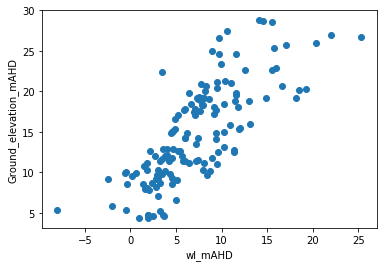

In [149]:
# To demonstrate the relationship between the groundwater elevation and ground elevation we 
# run a scatter plot


plt.scatter(df_water_tables_subset['water_table_elevation'].values,
           df_water_tables_subset['lid100m_elevation_mAHD'].values)

plt.xlabel('wl_mAHD')
plt.ylabel('Ground_elevation_mAHD')

plt.show()

In [ ]:
# Plot the bores on a basemap to get an idea of what the swl data looks like

coords = df_water_tables_subset[['Easting', 'Northing']].values


wte = df_water_tables_subset["water_table_elevation"].values

plotting_utils.plot_point_dataset(coords, "EPSG:28352", wte, 
                   colourbar_label = 'elevation', colour_scheme = 'viridis',
                    point_size=100)